### **Read Data**

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Laptop GPU is busy with rendering screen ...
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
import pickle
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
#data_dir = '../../Sensorfloors/summerschool2020/Robot_Data/train/*'
data_dir = '../Dataset_sensor_floor/Dataset_Final/02092022/train/*'
file_list = sorted(glob.glob(data_dir))

# dfs = []
# for input_file in file_list:
#     print('Loading:', input_file)
#     dfs.append(pd.read_csv(input_file).drop(['data'], axis=1))

In [3]:
# run_limit_dict = {
#     0: 1163,
#     1: 1164,
#     2: 3122,
#     3: 2142,
#     4: 835,
#     5: 1502,
#     6: 5571,
#     7: 1563,
#     8: 1489,
#     9: 1244,
#     10: 1699,
#     11: 2933,
#     12: 3093,
# }

# for i, df in enumerate(dfs):
#     print(i, len(df.vicon_X))
#     start = run_limit_dict[i] 
#     end = 3000
#     plt.plot(df.vicon_X[start:end], df.vicon_Y[start:end])
#     #print(np.sum(np.abs(np.diff(df.vicon_X[start:end])) > 1e-4))
#     #print(np.sum(np.abs(np.diff(df.vicon_y[start:end])) > 1e-4))


In [4]:
# import sys
# modules_dir = '../../Sensorfloors/REAML2020Hackathon/modules/'
# sys.path.insert(1, '../../Sensorfloors/REAML2020Hackathon/')

from modules_lib.data import KEYS as keys
from modules_lib.data import get_data_from_data_frame
from modules_lib.data import read_data

### Generate Pickle FIle

In [5]:
#Test read file and build frames

train = []
n_files = len(file_list)
y_list = []
t_list = []
X_list = []

path_pickle = '/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/Coding/sensor_floor_localization_data/'

os.chdir(path_pickle)

data_pickle_file = 'train_pickle_file_30092022.pkl'

for file_index, file in enumerate(file_list):
    print('Loading:', file)
        
    frames, y, t, X = read_data(file)
            
    X_list.append(X)
    y_list.append(y)
    t_list.append(t)
    train.append(frames)
    # write data
    pickle_data = [train, y_list, X_list, t_list]
    with open(data_pickle_file, 'wb') as handle:
        pickle.dump(pickle_data, handle, protocol=3)


#print(len(X_list),len(y_list),len(t_list))

In [6]:
train = []
n_files = len(file_list)
y_list = []
t_list = []
X_list = []

path_pickle = '/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/Coding/sensor_floor_localization_data/'

os.chdir(path_pickle)

data_pickle_file = 'data/train_pickle_file_09092022.pkl'

if os.path.exists(data_pickle_file):
    print('Reloading from pickle file')
    with open(data_pickle_file, 'rb') as handle:
         train, y_list, X_list, t_list = pickle.load(handle)
else:
    for file_index, file in enumerate(file_list):
        print('Loading:', file)
        
        frames, y, t, X = read_data(file)
            
        X_list.append(X)
        y_list.append(y)
        t_list.append(t)
        train.append(frames)
        
    # write data
    pickle_data = [train, y_list, X_list, t_list]
    with open(data_pickle_file, 'wb') as handle:
        pickle.dump(pickle_data, handle, protocol=3)

Reloading from pickle file


## Compute sensor normalization

In [7]:
#import numpy as np
# --------
# settings
# --------
norm_use_training_data = True
treat_sensors_equally = False
# --------

home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/'
os.chdir(home_path)

if treat_sensors_equally:
    norm_axes = (0, 1, 2)
else:
    norm_axes = 0

sensor_norm = np.zeros_like(X_list[0][0])
num_frames = 0
X_concat = np.concatenate(X_list, axis=0)
sensor_bias = np.nanmean(
    X_concat, axis=norm_axes, keepdims=True)[0]
sensor_std = np.nanstd(
    X_concat, axis=norm_axes, keepdims=True)[0] + 1e-7
# print('Total number of frames:', X_concat.shape[0])
# print(sensor_bias.shape)
# print(sensor_std.shape)


# with open('data/normalization/norm_data_00000100.pkl', 'rb') as handle:
with open('data/normalization/sensor_normalization_eqFalse_trTrue_09092022.pkl', 'rb') as handle:
    t_norm, X_norm = pickle.load(handle, encoding='latin1')
    sensor_bias2 = np.nanmean(
        X_norm, axis=norm_axes, keepdims=True)[0]
    sensor_std2 = np.nanstd(
        X_norm, axis=norm_axes, keepdims=True)[0] + 1e-7
    t_diff = np.diff(t_norm, axis=0)
    #plt.hist(t_diff, bins=30)
    
# print(np.nanmean(X_concat, axis=(0, 1, 2)))
# print(np.nanmean(X_norm, axis=(0, 1, 2)))

# print(np.nanstd(X_concat, axis=(0, 1, 2)))
# print(np.nanstd(X_norm, axis=(0, 1, 2)))

# save sensor normalization
if norm_use_training_data:
    pass
else:
    sensor_bias = sensor_bias2
    sensor_std = sensor_std2
    
# sensor_norm_file = 'data/normalization/sensor_normalization_eq{}_tr{}_09092022.pkl'.format(
#     treat_sensors_equally, norm_use_training_data)
sensor_norm_file = 'data/normalization/sensor_normalization_eqFalse_trTrue_09092022.pkl'.format(
    treat_sensors_equally, norm_use_training_data)
if os.path.exists(sensor_norm_file):
    print('WARNING: File {} already exists. Aborting!'.format(
        sensor_norm_file))
else:
    with open(sensor_norm_file, 'wb') as handle:
        pickle.dump([sensor_bias, sensor_std], 
                    handle, protocol=3)

print('Sensor normalization file:', sensor_norm_file)


Sensor normalization file: data/normalization/sensor_normalization_eqFalse_trTrue_09092022.pkl


In [8]:
sensor_bias[0]

array([[ 3.29595860e-02,  1.75348546e-01,  9.93075916e-01,
        -1.35619992e+00, -9.82027618e-02,  1.72397516e+00,
         1.04311545e+02, -3.55007600e+01,  1.36166848e+02,
        -7.44776144e+01],
       [ 2.66646157e-02,  1.71236793e-01,  1.04790019e+00,
        -8.59600339e-01, -9.62241371e-01,  1.47052232e+00,
        -6.97947522e+01, -3.32097018e+01,  9.19413716e+01,
        -7.52124605e+01],
       [ 6.25484381e-02,  1.62801342e-01,  9.92676968e-01,
        -6.51521787e-01,  6.13949254e-01, -4.74937988e-01,
         4.92136050e+01, -2.36622843e+02,  1.66373739e+02,
        -7.61867092e+01],
       [ 3.45211202e-02,  1.70125274e-01,  1.02620521e+00,
        -7.55061104e-01,  2.63261754e-01,  3.77575687e-01,
        -2.86430065e+01, -8.44710451e+01, -2.12324264e+01,
        -7.21437904e+01],
       [ 3.05386355e-03,  1.61402456e-01,  1.03402845e+00,
        -1.26356299e+00, -6.67566172e-02,  4.21704372e-01,
         6.99671617e+01, -7.50343301e+01,  1.76288714e+02,
        -7.

## Vicon Sensors

The sensors are arranged on a perfect rectangular 23x15 grid with distances of 1 in x-and y-direction.

In [9]:
vicon_file = 'vicon_node_positions.csv'
df_vicon = pd.read_csv(vicon_file)

# get arrays of coordinates
vicon_coords = np.empty([23, 15, 2])
for strip_id in range(1, 24):
    for node_id in range(1, 16):
        mask = np.logical_and(
            df_vicon['strip_id'] == strip_id,
            df_vicon['node_id'] == node_id)
        vicon_coords[strip_id-1, node_id-1, 0] = df_vicon.vicon_x[mask]
        vicon_coords[strip_id-1, node_id-1, 1] = df_vicon.vicon_y[mask]
print(df_vicon.min())
print(df_vicon.max())
print(df_vicon.node_id.size, 23*15)
df_vicon.head()

strip_id     1.000
node_id      1.000
vicon_x    -11.185
vicon_y     -6.425
dtype: float64
strip_id    23.000
node_id     15.000
vicon_x     10.815
vicon_y      7.575
dtype: float64
345 345


,strip_id,node_id,vicon_x,vicon_y
0,1.0,1.0,-11.185,7.575
1,1.0,2.0,-11.185,6.575
2,1.0,3.0,-11.185,5.575
3,1.0,4.0,-11.185,4.575
4,1.0,5.0,-11.185,3.575


In [10]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# for strip_id in range(1, 24):
#     mask = df_vicon.strip_id == strip_id
#     #print(np.unique(np.diff(df_vicon.vicon_x[mask])))
#     #print(np.unique(np.diff(df_vicon.vicon_y[mask])))
#     if np.sum(mask) > 0:
#         axes[0].scatter(df_vicon.vicon_x[mask], df_vicon.vicon_y[mask], 
#                         label='Strip: {:02d}'.format(strip_id))
#         axes[1].scatter(df_vicon.strip_id[mask], df_vicon.node_id[mask], 
#                         label='Strip: {:02d}'.format(strip_id))
#     axes[0].set_xlabel('Vicon x')
#     axes[0].set_ylabel('Vicon y')
#     axes[1].set_xlabel('Strip ID')
#     axes[1].set_ylabel('Node ID')
    

## Define Helper Functions

In [11]:
# decimals = 5

# dict_coords = {}
# dict_ids = {}
# for index, row in df_vicon.T.items():
#     x = np.round(row.vicon_x, decimals=decimals)
#     y = np.round(row.vicon_y, decimals=decimals)
#     dict_coords[(row.strip_id, row.node_id)] = (x, y)
#     dict_ids[(x, y)] = (row.strip_id, row.node_id)
    
# def get_ids(x, y):
#     x = np.round(x, decimals=decimals)
#     y = np.round(y, decimals=decimals)
#     return dict_ids[(x, y)]

# def get_coords(strip_id, row_id):
#     if isinstance(strip_id, int):
#         return dict_coords[(strip_id, row_id)]
#     else:
#         coords = [dict_coords[(s, r)] for s, r in zip(strip_id, row_id)]
#         return np.array(coords).T


In [12]:
# limit_dict = {
#     'r': [-100, -1e-1],
#     'ax': [-0.01, 0.01],
#     'ay': [-0.01, 0.01],
#     'az': [-0.01, 0.01],
#     'gx': [-5, 5],
#     'gy': [-5, 5],
#     'gz': [-5, 5],
#     'mx': [-400, 400],
#     'my': [-400, 400],
#     'mz': [-400, 400],
# }

# key_index = {key:i for i, key in enumerate(keys)}

# def normalize(X):
#     X_norm = np.array(X)
#     X_norm = (X_norm - sensor_bias) / sensor_std
#     return X_norm

# def get_data(run, index, key, normalized):
#     y = y_list[run][index]
#     X = X_list[run][index]
    
#     data = np.array(X[..., key_index[key]])
#     data[~np.isfinite(data)] = -float('inf')
    
#     if normalized:
#         bias = sensor_bias[..., key_index[key]]
#         std = sensor_std[..., key_index[key]]
#         data = (data - bias) / std
    
#     return y, X, data

# def print_frame(index, run=0, 
#                 ax=None, fig=None, add_colorbar=True, 
#                 key='r', key_as_title=False,
#                 normalized=True,
#                 y_pred=None,
#                 empty_data=False):
#     if ax is None:
#         fig, ax = plt.subplots()
    
#     # get data
#     y, X, data = get_data(run, index, key, normalized)
    
#     # get limits
#     if normalized:
#         limits = {
#             'vmax': 7,
#             'vmin': -7,
#         }
#     else:
#         limits = {}
#         # if key in limit_dict:
#         #     limits = {
#         #         'vmax': limit_dict[key][1],
#         #         'vmin': limit_dict[key][0],
#         #     }
#         # else:
#         #     limits = {}

#     if empty_data:
#         data *= float('nan')
    
#     pcmesh = ax.pcolormesh(
#         vicon_coords[:, :, 0], 
#         vicon_coords[:, :, 1], 
#         data,
#         cmap='RdBu',
#         **limits)
#     scat = ax.scatter(*y, marker='x', color='red', s=500)
    
#     artists = [pcmesh, scat]
#     if y_pred is not None:
#         scat_pred = ax.scatter(
#             *y_pred[index], marker='+', color='green', s=500)
#         artists.append(scat_pred)
    
#     if add_colorbar:
#         fig.colorbar(pcmesh)
#     if key_as_title:
#         title = ax.set_title(key)
#     else:
#         title = ax.set_title('Run {} | Frame: {:05d}'.format(
#             run, index))
#     if ax is None:
#         plt.show()
#         plt.close(fig)
#     return artists, ax, fig

# def print_complete_frame(index, run=0, axes=None, 
#                          fig=None, add_colorbar=True,
#                          normalized=True,
#                          empty_data=False,
#                          add_title=True,
#                          y_pred=None,
#                         ):
#     if axes is None:
#         fig, axes = plt.subplots(2, 5, figsize=(20, 5))
    
#     artists_list = []
#     for ax, key in zip(axes.flatten(), keys):
#         artists, _, _ = print_frame(
#             index=index, run=run, ax=ax, fig=fig,
#             add_colorbar=False, key=key,
#             key_as_title=True, 
#             normalized=normalized,
#             y_pred=y_pred,
#             empty_data=empty_data)
#         artists_list.append(artists)
#     if add_title:
#         title = fig.suptitle('Run {} | Frame: {:05d}'.format(
#             run, index))
#     else:
#         title = None
#     fig.tight_layout()
#     if axes is None:
#         plt.show()
#         plt.close(fig)
#     return artists_list, title, fig, axes
    

In [13]:
# for i in range(50, 60):
#     print_frame(i, run=0, key='r')
#     print_complete_frame(i, run=0)


In [14]:
# def create_y_gif(y_pred, y_true=None, 
#                  file_name='plots/gif_y_prediction.gif'):
#     fig, ax = plt.subplots()
#     fig.set_tight_layout(True)
    
#     num_frames = len(y_pred)
    
#     plot_dir = os.path.dirname(file_name)
#     if not os.path.isdir(plot_dir):
#         print('Creating directory:', plot_dir)
#         os.makedirs(plot_dir)
    
#     # Plot axis that persists (isn't redrawn)
#     title = ax.set_title('Frame: {:05d}'.format(0))
#     ax.set_xlabel('Vicon X [meter]')
#     ax.set_ylabel('Vicon Y [meter]')
#     min_x = np.min(vicon_coords[..., 0])
#     max_x = np.max(vicon_coords[..., 0])
#     min_y = np.min(vicon_coords[..., 1])
#     max_y = np.max(vicon_coords[..., 1])
#     ax.set_xlim(min_x - 1, max_x + 1)
#     ax.set_ylim(min_y - 1, max_y + 1)
    
#     artists = [ax, title]
    
#     if y_pred is not None:
#         scat_pred = ax.scatter(
#             0, 0, marker='+', color='green', s=500,
#             label='Prediction',
#         )
#         artists.append(scat_pred)
#     if y_true is not None:
#         scat_true = ax.scatter(
#             0, 0, marker='+', color='orange', s=500,
#             label='True',
#         )
#         artists.append(scat_true)
#     ax.legend()
    
#     def init():
#         return artists

#     def update(i):
#         # Update the line and the axes (with a new xlabel). Return a tuple of
#         # "artists" that have to be redrawn for this frame.
#         cnt = 2
#         if y_pred is not None:
#             scat_pred = artists[cnt]
#             cnt += 1
#             scat_pred.set_offsets(y_pred[i])
#         if y_true is not None:
#             scat_true = artists[cnt]
#             cnt += 1
#             scat_true.set_offsets(y_true[i])
#         artists[1].set_text('Frame: {:05d}'.format(i))
#         #artists[0].set_xlim(min_x - 1, max_x + 1)
#         #artists[0].set_ylim(min_y - 1, max_y + 1)
#         return artists

#     # FuncAnimation will call the 'update' function for each frame; here
#     # animating over 10 frames, with an interval of 200ms between frames.
#     anim = FuncAnimation(
#         fig, update, frames=tqdm(np.arange(0, num_frames)), 
#         interval=200, blit=False, init_func=init)
#     anim.save(file_name, dpi=80, writer='imagemagick')

# def create_gif(key, run, file_name='plots/gif_run{run}_{key}.gif'):
#     fig, ax = plt.subplots()
#     fig.set_tight_layout(True)
    
#     file_name = file_name.format(run=run, key=key)
#     plot_dir = os.path.dirname(file_name)
#     if not os.path.isdir(plot_dir):
#         print('Creating directory:', plot_dir)
#         os.makedirs(plot_dir)

#     # Plot a scatter that persists (isn't redrawn) and the initial line.
#     print_frame(i, run=run, ax=ax, fig=fig, key=key)

#     def update(i):
#         # Update the line and the axes (with a new xlabel). Return a tuple of
#         # "artists" that have to be redrawn for this frame.
#         artists = print_frame(
#             i, run=run, ax=ax, fig=fig, 
#             add_colorbar=False, key=key)
#         return artists, ax

#     # FuncAnimation will call the 'update' function for each frame; here
#     # animating over 10 frames, with an interval of 200ms between frames.
#     anim = FuncAnimation(fig, update, frames=tqdm(np.arange(0, min(100, len(frames)))), 
#                          interval=200)
#     anim.save(file_name, dpi=80, writer='imagemagick')

# def create_complete_gif(run, file_name='plots/gif_run{run}{norm}.gif',
#                         normalized=True, num_frames=100):
#     fig, axes = plt.subplots(2, 5, figsize=(20, 5))
#     fig.set_tight_layout(True)
    
#     if normalized:
#         norm = '_normalized'
#     else:
#         norm = ''
#     file_name = file_name.format(run=run, norm=norm)
#     plot_dir = os.path.dirname(file_name)
#     if not os.path.isdir(plot_dir):
#         print('Creating directory:', plot_dir)
#         os.makedirs(plot_dir)

#     # Plot a scatter that persists (isn't redrawn) and the initial line.
#     print_complete_frame(i, run=run, axes=axes, fig=fig, 
#                          normalized=normalized)
#     def init():
#         pass
    
#     def update(i):
#         # Update the line and the axes (with a new xlabel). Return a tuple of
#         # "artists" that have to be redrawn for this frame.
#         print_complete_frame(
#             i, run=run, axes=axes, fig=fig,
#             normalized=normalized)

#     # FuncAnimation will call the 'update' function for each frame; here
#     # animating over 10 frames, with an interval of 200ms between frames.
#     anim = FuncAnimation(
#         fig, update, 
#         frames=tqdm(np.arange(0, min(num_frames, len(y_list[run])))), 
#         interval=200, init_func=init)
#     anim.save(file_name, dpi=80, writer='imagemagick')
#     plt.close(fig)

# def create_complete_gif2(run, file_name='plots/gif_run{run}{norm}.gif',
#                          normalized=True, y_pred=None,
#                          num_frames=100):
#     fig, axes = plt.subplots(2, 5, figsize=(20, 5))
#     fig.set_tight_layout(True)
    
#     if normalized:
#         norm = '_normalized'
#     else:
#         norm = ''
#     file_name = file_name.format(run=run, norm=norm)
#     plot_dir = os.path.dirname(file_name)
#     if not os.path.isdir(plot_dir):
#         print('Creating directory:', plot_dir)
#         os.makedirs(plot_dir)

#     # Plot a scatter that persists (isn't redrawn) and the initial line.
#     artists_list, title, _, _ = print_complete_frame(
#         0, run=run, axes=axes, fig=fig, 
#         y_pred=y_pred,
#         normalized=normalized, 
#         add_title=False,
#         empty_data=True)
#     title = axes[0, 0].text(
#         .45, 0.9, '', transform = axes[0, 0].transAxes)
#     pcmesh_list = [a[0] for a in artists_list]
#     scat_list = [a[1] for a in artists_list]
#     all_artists = list(pcmesh_list)
#     all_artists.extend(scat_list)
#     if y_pred is not None:
#         scat_pred_list = [a[2] for a in artists_list]
#         all_artists.extend(scat_pred_list)
#     all_artists.append(title)
    
#     def init():
#         return all_artists

#     def update(i):
#         # Update the line and the axes (with a new xlabel). Return a tuple of
#         # "artists" that have to be redrawn for this frame.
#         for j, key in enumerate(keys):
#             # get new data
#             y, X, data = get_data(
#                 run=run, index=i, key=key, normalized=normalized)
            
#             # set new data
#             if y_pred is None:
#                 pcmesh, scat = artists_list[j]
#             else:
#                 pcmesh, scat, scat_pred = artists_list[j]
#                 scat_pred.set_offsets(
#                     [y_pred[i, 0], y_pred[i, 1]])
#             pcmesh.set_array(data[:-1,:-1].ravel())
#             scat.set_offsets([y[0], y[1]])
            
#             title.set_text('Run {} | Frame: {:05d}'.format(
#                 run, i))

#         return all_artists

#     # FuncAnimation will call the 'update' function for each frame; here
#     # animating over 10 frames, with an interval of 200ms between frames.
#     anim = FuncAnimation(
#         fig, update, 
#         frames=tqdm(np.arange(0, min(num_frames, len(y_list[run])))), 
#         interval=200, blit=True, init_func=init)
#     anim.save(file_name, dpi=80, writer='imagemagick')
#     plt.close(fig)

## Investigate Value Distributions

In [15]:
# bins = np.linspace(-5, 5, 100)

# fig, ax = plt.subplots(figsize=(9, 6))
# for run in range(1):
#     for key in keys[6:9]:
#         X_norm = normalize(X_list[run])
#         X_norm = X_list[run]
#         ax.hist(X_norm[..., key_index[key]].flatten(),
#                 bins=bins, histtype='step',
#                 label='{} | {}'.format(run, key),
#                 density=True,
#                )
# ax.legend()
# ax.axvline(0, color='0.8', ls='--')
# #ax.set_yscale('log')
        

#### Investigate Time Steps

Times between steps seems to be roughly constant and around 0.23 seconds. 

In [16]:
# #Convert unix timestamps to Julian date format
# def getJulianFromUnix(unixSecs):
#     return (unixSecs/86400.0)+2440587.5

# run = 8
# if False:
#     num_frames = len(train[run])
#     times = np.empty(num_frames)
#     offset = 2459794.5 #Julian epoch for 03.08.2022//Julian epoch for 5th August 2020: 2459067.00
#     for i in tqdm(range(num_frames)):
#         time_stamps = train[run][i]['data'].timestamp
#         time_i = []
#         for time_stamp in time_stamps:
#             time_stamp = getJulianFromUnix(time_stamp)
#             time_i.append(time_stamp - offset)
#         times[i] = np.mean(time_i)  * 24 * 60 * 60
# else:
#     times = t_list[run][:, 0]
    


In [17]:
# time_diffs = np.diff(times)
# plt.hist(time_diffs, bins=100)
# plt.xlabel('$\Delta t$ [s]')
# plt.yscale('log')
# plt.show()


## Fit Kernel Density for Velocity and Acceleration

In [18]:
# from sklearn.neighbors import KernelDensity
# from scipy.optimize import minimize
# from scipy.interpolate import UnivariateSpline
# from egenerator.utils import basis_functions
# from keras.utils import GeneratorEnqueuer, to_categorical, np_utils

# from modules_lib.data import get_vel_and_acc
# #TF_ENABLE_ONEDNN_OPTS=0

# def get_kde_data(every_nth):
#     y_train_list = []
#     t_train_list = []
#     for train_index in range(8):
#         t_train = np.array(t_list[train_index])[::every_nth]
#         y_train = np.array(y_list[train_index])[::every_nth]
#         t_train_list.append(t_train)
#         y_train_list.append(y_train)

#     y = np.concatenate(y_train_list, axis=0)
#     t = np.concatenate(t_train_list, axis=0)
#     return y, t

# def build_kde(every_nth, 
#               kernel='linear', 
#               bandwidth=0.005,
#               atol=1e-2,
#               rtol=1e-1,
#               sparsity=1,
#              ):
#     pos, t = get_kde_data(every_nth)
#     vel_abs, acc_abs, acc_parallel, acc_perp = \
#         get_vel_and_acc(pos, t)

#     acc_perp_abs = np.abs(acc_perp)

#     kde_data = np.concatenate(
#         [
#             #acc_perp_abs, 
#             #acc_parallel, 
#             vel_abs,
#         ],
#         axis=1,
#     )
    
#     # shuffle so that randomly chosing points via sparsity
#     # obtains uncorrelated points
#     np.random.shuffle(kde_data)
    
#     kde = KernelDensity(
#         kernel=kernel, bandwidth=bandwidth,
#         atol=atol, rtol=rtol,
#     ).fit(kde_data[::sparsity])
#     return kde

# def eval_mixture_model(x, params):
    
#     # normalize scale
#     params[:, 3] /= np.sum(params[:, 3])

#     llh = np.log(np.sum(basis_functions.asymmetric_gauss(
#         x, 
#         mu=params[:, 0], 
#         sigma=params[:, 1], 
#         r=params[:, 2],
#     ) * params[:, 3], axis=1))
#     return llh

# def get_mixture_model(x, n=3):
#     """Get a mixture model for the 1D data x
#     Parameters:
#     -----------
#     x: array_like
#         The data for which to build the mixture model.
#     n: int
#         The number of asymmetric Gaussians to use.
        
#     Returns:
#     -------
#     function:
#         The mixture model function:
#         f(x) -> log prob
#     """
#     def loss(params):
#         params = np.reshape(params, [n, 4])
        
#         # make sure sigma and r are positive
#         if (params[:, 1:3] <= 1e-8).any():
#             return np.inf
        
#         neg_llh = -eval_mixture_model(x, params)
#         return np.sum(neg_llh)
    
#     params = np.empty([n, 4])
#     params[:, 0] = np.linspace(0, 0.707, n)
#     params[:, 1:] = 1.
#     params[0, 1] = 0.0001
#     params[0, 2] = 100
#     params[-1, 1] = 100
#     params[-1, 2] = 0.01
#     params = params.flatten()
#     result = minimize(
#         fun=loss,
#         x0=params,
#         method='Nelder-Mead',
#     )
#     params = np.reshape(result.x, [n, 4])
    
#     def mixture_model(x):
#         return eval_mixture_model(x, params)
    
#     return mixture_model
    
# def build_mm(every_nth, n=1):
#     pos, t = get_kde_data(every_nth)
#     vel_abs, acc_abs, acc_parallel, acc_perp = \
#         get_vel_and_acc(pos, t)

#     acc_perp_abs = np.abs(acc_perp)
    
#     mm = get_mixture_model(vel_abs, n)
#     return mm

# def build_spline(every_nth):
#     pos, t = get_kde_data(every_nth)
#     vel_abs, acc_abs, acc_parallel, acc_perp = \
#         get_vel_and_acc(pos, t)

#     vel_abs_sorted = np.sort(vel_abs[:, 0])
#     x = vel_abs_sorted[::100]
    
#     hist, bin_edges = np.histogram(vel_abs, bins=x, density=True)
#     x_mids = bin_edges[:-1] + np.diff(bin_edges)*0.5
#     weights = np.ones_like(x_mids)
#    # weights[x_mids < 0.01] = 10
#    # weights[np.abs(x_mids - 0.7105) < 0.02 ] = 10
    
#     s =  1e6 * len(weights) / len(vel_abs)**2
    
#     spline = UnivariateSpline(
#         x_mids, hist, s=s, k=2, ext=1, w=weights)
#     return spline

# kdes = [build_kde(e) for e in tqdm(range(1, 26))]
# splines = [build_spline(e) for e in tqdm(range(1, 26))]
# #mixture_models = {e: build_mm(e) for e in tqdm(range(1, 13))}

# def write_to_file(data, file_name):
#     file_dir = os.path.dirname(file_name)

#     if not os.path.exists(file_dir):
#         print('Creating directory:', file_dir)
#         os.makedirs(file_dir)

#     with open(file_name, 'wb') as handle:
#         pickle.dump(data, handle, protocol=2)
        
# # ------------------------------
# # write kdes and splines to file
# # ------------------------------
# write_to_file(kdes, 'data/kdes/kde_vel_abs_09092022.pkl')
# write_to_file(splines, 'data/splines/spline_vel_abs_09092022.pkl')


In [19]:
# nth = 2

# pos, t = get_kde_data(nth)
# vel_abs, acc_abs, acc_parallel, acc_perp = \
#     get_vel_and_acc(pos, t)

# acc_perp_abs = np.abs(acc_perp)

# kde_data = np.concatenate(
#     [acc_perp_abs, acc_parallel, vel_abs],
#     axis=1,
# )
# print('kde_data', kde_data.shape)

# kde = KernelDensity(
#     kernel='epanechnikov', bandwidth=0.01).fit(vel_abs)
#     #kernel='gaussian', bandwidth=0.0000015).fit(vel_abs)

# x = np.linspace(-0.1, 0.8, 1000)
# bins = np.linspace(-0.1, 0.8, 100)
# #plt.plot(x, np.exp(kde.score_samples(x[:, None])), label='KDE')
# plt.plot(x, np.exp(kdes[nth].score_samples(x[:, None])), label='KDE2')
# plt.plot(x, splines[nth](x), label='Spline')
# #plt.plot(x, np.exp(mixture_models[1](x[:, None])), label='MM')

# plt.hist(vel_abs, bins='doane', label='|Velocity|',
#          density=True, histtype='step')
# #plt.hist(acc_parallel, bins=100, label='Par. Acc.',
# #         density=True, histtype='step')
# #plt.hist(acc_perp_abs, bins=100, label='|Perp. Acc.|',
# #         density=True, histtype='step')
# #plt.hist(acc_abs, bins=100, label='Abs Acc.',
# #         density=True, histtype='step')
# #plt.ylim(0, 10)
# plt.axvline(0., color='0.5', label='Value: 0.')
# plt.axvline(0.7105, color='0.5', label='Value: 0.7105')
# #plt.xlim(.69, 0.73)
# #plt.xlim(-0.001, 0.1)
# plt.yscale('log')
# plt.title('Every nth: {}'.format(nth))
# plt.legend()
# plt.show()

# #plt.hexbin(vel_abs[:-1], acc_perp[1:], mincnt=1)
# plt.hexbin(vel_abs, np.abs(acc_perp), mincnt=1)
# plt.xlabel('|Velocity| [m/s]')
# plt.ylabel('|Acc. Perpendicular| [m/s^2]')
# plt.show()

# plt.hexbin(vel_abs, acc_parallel, mincnt=1)
# plt.xlabel('|Velocity| [m/s]')
# plt.ylabel('Acc. Parallel [m/s^2]')
# plt.show()

# plt.hexbin(np.abs(acc_perp), acc_parallel, mincnt=1)
# plt.xlabel('|Acc. Perpendicular| [m/s^2]')
# plt.ylabel('Acc. Parallel [m/s^2]')
# plt.show()

# plt.hexbin(vel_abs, acc_abs, mincnt=1)
# plt.xlabel('|Velocity| [m/s]')
# plt.ylabel('|Acceleration| [m/s^2]')
# plt.show()


## Collect Data for sensor-based Model

In [20]:
# every_nth = 2

# X_train_list = []
# X_llh_list = []
# y_vel_list = []
# y_acc_list = []
# y_acc_parallel_list = []
# y_acc_perp_list = []
# for train_index in range(8):
#     X_train = np.array(X_list[train_index])[::every_nth]
#     t_train = np.array(t_list[train_index])[::every_nth]
#     y_train = np.array(y_list[train_index])[::every_nth]
    
#     vel_abs, acc_abs, acc_parallel, acc_perp = \
#         get_vel_and_acc(y_train, t_train)
    
#     dt = np.diff(t_train, axis=0)

#     y_pos = np.array(y_train)
#     y_vel = np.zeros_like(y_pos)
#     y_vel[1:] = np.diff(y_pos, axis=0) / dt
#     y_acc = np.zeros_like(y_pos)
#     y_acc[1:] = np.diff(y_vel, axis=0) / dt

#     # compute relative positions to each sensor
#     y_pos_rel = (
#         np.expand_dims(vicon_coords, axis=0) - 
#         np.reshape(y_pos, [-1, 1, 1, 2])
#     )


#     # gather input data for LLH model
#     y_vel_exp = np.tile(np.reshape(y_vel, [-1, 1, 1, 2]),
#                         [1, 23, 15, 1])
#     X_llh = np.concatenate([y_pos_rel, y_vel_exp], axis=-1)
    
#     X_train_list.append(X_train)
#     X_llh_list.append(X_llh)
#     y_vel_list.append(y_vel)
#     y_acc_list.append(y_acc)
#     y_acc_perp_list.append(acc_perp)
#     y_acc_parallel_list.append(acc_parallel)

# X_llh = np.concatenate(X_llh_list, axis=0)
# X_train = np.concatenate(X_train_list, axis=0)
# y_acc = np.concatenate(y_acc_list, axis=0)
# y_vel = np.concatenate(y_vel_list, axis=0)
# y_acc_parallel = np.concatenate(y_acc_parallel_list, axis=0)
# y_acc_perp = np.concatenate(y_acc_perp_list, axis=0)

# X_llh_mean = np.mean(X_llh, axis=0, keepdims=True)
# X_llh_std = np.std(X_llh, axis=0, keepdims=True)

# X_train_norm = (X_train - sensor_bias) / (sensor_std*10)
# # set NaN values to 0
# X_train[~np.isfinite(X_train)] = 0.
# X_train_norm[~np.isfinite(X_train)] = 0.

# print('vicon_coords', vicon_coords.shape)
# print('y_pos_rel', y_pos_rel.shape)
# print('y_vel', y_vel.shape)
# print('y_pos', y_pos.shape)
# print('y_vel_exp', y_vel_exp.shape)
# print('X_llh', X_llh.shape)
# print('X_llh_mean', X_llh_mean.shape)

In [21]:
# bins = np.linspace(-1.25, 1.25, 100)
# #bins = np.linspace(0.99, 1.03, 100)
# plt.hist(y_vel[:, 0], bins=bins, label='v_x',
#          histtype='step')
# plt.hist(y_vel[:, 1], bins=bins, label='v_y',
#          histtype='step')
# plt.hist(np.hypot(y_vel[:, 0], y_vel[:, 1]) / np.sqrt(2.), 
#          bins=bins, label='|v|',
#          histtype='step')
# plt.axvline(1.02, color='0.8')
# plt.legend()
# plt.title('Every Nth: {}'.format(every_nth))
# plt.yscale('log')

## Predict with basic CNN

In [22]:
import tensorflow as tf
# from tensorflow.keras import datasets, layers, models
from egenerator.utils import basis_functions

import tensorflow as tf
from keras import datasets, layers, models
from keras import layers as tfs

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.utils import GeneratorEnqueuer, to_categorical, np_utils


2022-09-13 10:56:28.845740: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [23]:
def limit_sigma(y_pred):
    mu = y_pred[..., :2]
    sigma = y_pred[..., 2:4]
    r = y_pred[..., 4:]
    sigma = tf.nn.elu(sigma) + 1.001
    r = tf.nn.elu(r) + 1.001
    y_pred = tf.concat([mu, sigma, r], axis=-1)
    return y_pred


model_name = 'coords2'
add_coordinates = True

num_inputs = 4
if add_coordinates:
    num_inputs = 6

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(23, 15, num_inputs))) 

if model_name == 'basic':
    model.add(layers.Dropout(rate=0.01)) 
    model.add(layers.Conv2D(8, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(16, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(16, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='elu'))
    
    optimizer = tf.optimizers.Adam(
        learning_rate=0.001,
        amsgrad=False,
    )
    batch_size = 32
    epochs = 20
    
elif model_name == 'test':
    model.add(layers.Dropout(rate=0.01)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(128, activation='elu'))
    
    optimizer = tf.optimizers.Adam(
        learning_rate=0.0001,
        amsgrad=True,
    )
    batch_size = 1
    epochs = 50 #25 (current best)#20

elif model_name == 'augmented':
    model.add(layers.Dropout(rate=0.01)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(128, activation='elu'))
    
    optimizer = tf.optimizers.Adam(
        learning_rate=0.0001,
        amsgrad=True,
    )
    batch_size = 1
    epochs = 25 
    
elif model_name == 'coords':
    #model.add(layers.Dropout(rate=0.01)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    #model.add(layers.Dropout(rate=0.05)) 
    #model.add(layers.SpatialDropout2D(rate=0.05)) 
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    #model.add(layers.Dropout(rate=0.05)) 
    #model.add(layers.SpatialDropout2D(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    #model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(128, activation='elu'))
    
    optimizer = tf.optimizers.Adam(
        learning_rate=0.0001,
        amsgrad=True,
    )
    batch_size = 1
    epochs = 35
elif model_name == 'coords2':
    #model.add(layers.Dropout(rate=0.01)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    #model.add(layers.Dropout(rate=0.05)) 
    #model.add(layers.SpatialDropout2D(rate=0.01)) 
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    #model.add(layers.Dropout(rate=0.05)) 
    #model.add(layers.SpatialDropout2D(rate=0.01)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    #model.add(layers.Dropout(rate=0.05))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(128, activation='elu'))
    
    optimizer = tf.optimizers.Adam(
        learning_rate=0.0001,
        amsgrad=True,
    )

    #optimizer = tf.optimizers.Adam(amsgrad=True)

    #kernel_regulizer = tf.keras.regularizers.l1(1e-5)
    
    batch_size = 1
    epochs = 35 
else:
    raise ValueError
model.add(layers.Dense(6))    
model.add(layers.Lambda(limit_sigma))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 15, 64)        3520      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 15, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 15, 64)        36928     
                                                                 
 average_pooling2d (AverageP  (None, 11, 7, 64)        0         
 ooling2D)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 7, 64)         36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 7, 64)         36928     
                                                        

2022-09-13 10:56:30.483846: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-13 10:56:30.483891: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: irfanflw-XPS-15-9510
2022-09-13 10:56:30.483896: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: irfanflw-XPS-15-9510
2022-09-13 10:56:30.484191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-13 10:56:30.484210: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-13 10:56:30.484213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-13 10:56:30.484783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the follow

In [24]:
from modules_lib.model import loss_fun

model.compile(optimizer=optimizer, loss=loss_fun)

In [25]:
X_train_list = []
y_train_list = []
t_train_list = []
for train_index in range(10):
    X_train = np.array(X_list[train_index])
    X_train = (X_train - sensor_bias) / sensor_std
    X_train[~np.isfinite(X_train)] = 0
    y_train = np.array(y_list[train_index])
    t_train = np.array(t_list[train_index])
    
    # limit frame numbers
    # end = run_limit_dict[train_index] 
    # X_train = X_train[:end]
    # y_train = y_train[:end]
    # t_train = t_train[:end]
    
    X_train_list.append(X_train[..., 6:])
    #X_train_list.append(X_train)
    y_train_list.append(y_train)
    t_train_list.append(t_train)
    
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
t_train = np.concatenate(t_train_list, axis=0)
y_train_norm = y_train / 10.
print('X_train', X_train.shape)

X_train (60463, 23, 15, 4)


#### Data Augmentation

In [26]:
# # get coordinates of symmetry axis
# center_x, center_y = np.mean(vicon_coords, axis=(0, 1))

# def flip_along_x_axis(X, y):
#     X = np.array(X[:, :, ::-1, :])
#     y = np.array(y)
#     y[:, 1] = y[:, 1] - 2*(y[:, 1] - center_y)
#     return X, y

# def flip_along_y_axis(X, y):
#     X = np.array(X[:, ::-1, :, :])
#     y = np.array(y)
#     y[:, 0] = y[:, 0] - 2*(y[:, 0] - center_x)
#     return X, y

# def convert_to_cell(x, y):
#     '''
#     This function takes a measurement in origin frame (x,y), convert it
#     to a cell number and return it as (strip_id, node_id)
#     '''
#     def translate(value, leftMin, leftMax, rightMin, rightMax):
#         # Figure out how 'wide' each range is
#         leftSpan = leftMax - leftMin
#         rightSpan = rightMax - rightMin

#         # Convert the left range into a 0-1 range (float)
#         valueScaled = 1.*(value - leftMin) / leftSpan

#         # Convert the 0-1 range into a value in the right range.
#         return rightMin + (valueScaled * rightSpan)

#     predict_cell = np.zeros([len(y), 2])
#     predict_cell[:, 0] = x + 11.185
#     predict_cell[:, 1] = translate(y, -15+7.575, 7.575, 15, 0)
#     predict_cell = np.round(predict_cell)

#     return predict_cell
    
# def shift_columns(X, y, n=4, keep_unshifted=True):

#     # get current cell indices
#     strip_id = convert_to_cell(y[:,0], y[:,1])[:, 0]
    
#     # get events where there is enough space left and right
#     mask = np.logical_and(strip_id > n, strip_id < 22-n)
    
#     if not keep_unshifted:
#         X = np.array(X[mask])
#         y = np.array(y[mask])
#         strip_id = strip_id[mask]

#     # compute maximum allowed shift left or right
#     shift_left = np.clip(strip_id - n, 0, float('inf'))
#     shift_right = np.clip(22 - strip_id - n, 0, float('inf'))

#     # sample random shift
#     # Note: shift_right won't get sampled, but we use 0 
#     # for that
#     shifts = np.random.randint(
#         low=-shift_left, 
#         high=np.clip(shift_right, 1, float('inf')),
#     )
#     mask_z = shifts == 0
#     shifts[mask_z] = shift_right[mask_z]
#     mask = shifts == 0
#     shifts[mask_z] = shift_left[mask_z]
    
#     if keep_unshifted:
#         shifts[mask] = 0
    
#     # shift data
#     X = np.roll(X, shifts, axis=1)
#     y[:, 0] += shifts
    
#     return X, y

# def add_flip_augmentation(X, y):
#     X_x, y_x = flip_along_x_axis(X, y)
#     X_y, y_y = flip_along_y_axis(X, y)
#     X = np.concatenate((X, X_x, X_y), axis=0)
#     y = np.concatenate((y, y_x, y_y), axis=0)
#     return X, y

# def add_augmentations(X, y, n_shifts=3):
#     #return add_flip_augmentation(X, y)
#     X_list = [X]
#     y_list = [y]
#     for i in range(n_shifts):
#         X_shift, y_shift = shift_columns(
#             X, y, keep_unshifted=False)
#         X_list.append(X_shift)
#         y_list.append(y_shift)
#     X = np.concatenate(X_list, axis=0)
#     y = np.concatenate(y_list, axis=0)  
    
#     return add_flip_augmentation(X, y)

# X_train2, y_train2 = add_augmentations(X_train, y_train)
# print('X_train2', X_train2.shape)


#### Fit Model

In [27]:
from modules_lib.data import append_vicon_coords

if add_coordinates:
    X_train_ext = append_vicon_coords(X_train)
else:
    X_train_ext = X_train
    
print('X_train_ext', X_train_ext.shape)
#reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
history = model.fit(x=X_train_ext, y=y_train, epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.10)

X_train_ext (60463, 23, 15, 6)
Epoch 1/35
54416/54416 [==============================] - 151s 3ms/step - loss: 1.4254 - val_loss: 7.1487
Epoch 2/35
54416/54416 [==============================] - 150s 3ms/step - loss: 0.9471 - val_loss: 9.6446
Epoch 3/35
54416/54416 [==============================] - 149s 3ms/step - loss: 0.8435 - val_loss: 10.4699
Epoch 4/35
54416/54416 [==============================] - 151s 3ms/step - loss: 0.7825 - val_loss: 12.0654
Epoch 5/35
54416/54416 [==============================] - 161s 3ms/step - loss: 0.7391 - val_loss: 15.8664
Epoch 6/35
54416/54416 [==============================] - 161s 3ms/step - loss: 0.7057 - val_loss: 13.1476
Epoch 7/35
54416/54416 [==============================] - 162s 3ms/step - loss: 0.6793 - val_loss: 17.3123
Epoch 8/35
54416/54416 [==============================] - 162s 3ms/step - loss: 0.6556 - val_loss: 15.6336
Epoch 9/35
54416/54416 [==============================] - 156s 3ms/step - loss: 0.6348 - val_loss: 19.6703
Epoch 10

KeyboardInterrupt: 

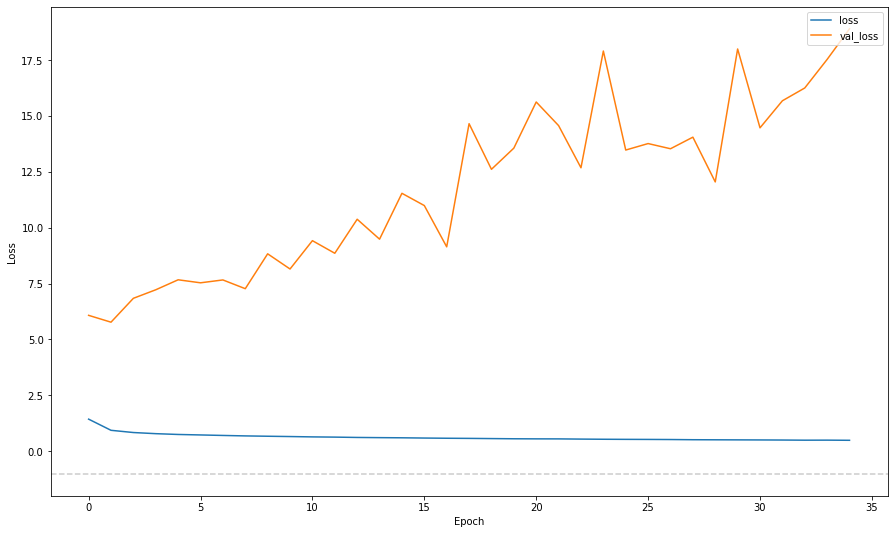

In [ ]:
fig = plt.figure(figsize=(15, 9))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.axhline(-1, color='0.8', ls='--')


In [ ]:
fig.savefig('data/models/loss_model_coords2_0003.png', dpi=300)

### Save Model to file

In [ ]:
# -----------------
# Define Model Name
# -----------------
model_file = 'data/models/model_{}_{:04d}_l1reg'
# -----------------

#plt.savefig('data/models/loss_model_coords2_0003_l1reg.png')

# check if directory needs to be created
model_dir = os.path.dirname(model_file.format(model_name, 0))
if not os.path.exists(model_dir):
    print('Creating Directory {}'.format(model_dir))
    os.makedirs(model_dir)

for i in range(1000):
    model_file_i = model_file.format(model_name, i)
    if not os.path.exists(model_file_i):
        print('Saving prediction to:', model_file_i)
        model.save(model_file_i)
        
        # save normalization model
        meta_file = os.path.join(
            model_file_i, 'normalization.txt')
        with open(meta_file, "w") as text_file:
            text_file.write(sensor_norm_file)
        
        # save meta data
        meta_file = os.path.join(
            model_file_i, 'meta.pkl')
        meta_data = {
            'add_coordinates': add_coordinates,
            'sensor_norm_file': sensor_norm_file,
        }
        with open(meta_file, "wb") as handle:
            pickle.dump(meta_data, handle, protocol=2)
        break


Saving prediction to: data/models/model_coords2_0000_l1reg


INFO:tensorflow:Assets written to: data/models/model_coords2_0000_l1reg/assets


INFO:tensorflow:Assets written to: data/models/model_coords2_0000_l1reg/assets


<Figure size 432x288 with 0 Axes>

## Evaluate Performance of Model 

#### Create ModelWrapper Instance

In [ ]:
# from modules_lib.model import ModelWrapper

# model_file_i = 'data/models/model_coords2_0001'

# model_wrapper = ModelWrapper(model_file_i)


Loaded Model with settings:
	add_coordinates: True
	sensor_norm_file: data/normalization/sensor_normalization_eqFalse_trTrue_09092022.pkl


#### Run Evaluation

In [ ]:
# from modules_lib.model import likelihood, postprocess
# from modules_lib.data import get_vel_and_acc

# for normalized in [True]:
#     for run in range(7, 9):
#         print('Creating Run {} with normalization {}'.format(
#             run, normalized))
        
#         # get data
#         t_data = np.array(t_list[run])
#         X_data = np.array(X_list[run])
#         y_true = np.array(y_list[run])
        
#         # limit data and frequency
#         num_frames = 100
#         start = 0
#         every_nth = 2
#         t_data = t_data[::every_nth][start:start + num_frames]
#         y_true = y_true[::every_nth][start:start + num_frames]
#         X_data = X_data[::every_nth][start:start + num_frames]
        
#         # run ModelWrapper prediction before we alte the
#         # data tensors
#         mu_wrapper = model_wrapper.predict(
#             X_data, t_data, run_post_processing=True)
        
#         X_data = (X_data - sensor_bias) / sensor_std
#         X_data[~np.isfinite(X_data)] = 0
#         #X_data, y_true = flip_along_y_axis(X_data, y_true)
#         #X_data, y_true = shift_columns(X_data, y_true, n=15)
#         X_data = X_data[..., 6:]
        
#         if add_coordinates:
#             X_data = append_vicon_coords(X_data)

#         y_pred = model.predict(X_data)

#         # undo normalization of y_pred during training
#         # y_pred *= 10.
        
#         mu = y_pred[..., :2]
#         sigma = y_pred[..., 2:4]
#         r = y_pred[..., 4:]
        
#         # Run Evaluation
#         print('Plain Model Prediction')
#         print(np.mean(np.sum(np.sqrt((mu - y_true)**2), axis=1)))
#         vel, acc = get_vel_and_acc(mu, t_data)[:2]
#         print(np.max(vel), np.max(acc))
        
#         if False:
#             mu = postprocess(mu, sigma, r, t_data, 
#                              pre_fitting_size=None)

#             # Run Evaluation
#             print('After Post-Processing')
#             print(np.mean(np.sum(np.sqrt((mu - y_true)**2), axis=1)))
#             print(np.mean((mu - y_true)**2))
#             vel, acc = get_vel_and_acc(mu, t_data)[:2]
#             print(np.max(vel), np.max(acc))
        
#         # Run Evaluation
#         print('Model Wrapper Class')
#         print(np.mean(np.sum(np.sqrt((mu_wrapper - y_true)**2), axis=1)))
#         print(np.mean((mu_wrapper - y_true)**2))
#         vel, acc = get_vel_and_acc(mu_wrapper, t_data)[:2]
#         print(np.max(vel), np.max(acc))
        
#         if False:
#             create_complete_gif2(
#                 run, normalized=normalized, num_frames=num_frames,
#                 y_pred=mu,
#             )

Creating Run 7 with normalization True
X_shape predict: (100, 23, 15, 10)
Mean failed:
[2.02285323 2.84401212 2.20552353 2.08048548 2.12967179 3.34280563
 2.66525769 2.02812542 2.22889796 2.31510376 2.06117632 2.11478476
 2.09227034 2.60621595 2.17925562 2.23293437 2.32687703 2.56042952
 2.38223076 2.70935758 2.61605747 2.60023533 2.5251476  2.15304259
 2.10108272 2.27446781 2.12299271 2.58230939 2.58571718 2.28063009
 2.05089274 2.20207823 2.03951296 2.19608443 2.99700269 2.05271477
 4.18568263 2.09699457 2.37057273 2.56987833 2.46495337 2.31984081
 2.44548203 2.64629758 2.20801888 2.67940603 2.30510928 2.18962689
 2.40895177 2.11449688 7.94224418 3.08529683 2.02336384 2.01685098
 2.28765353 2.10655026 2.20580822 2.04106542 2.97120956 2.18790444
 2.87870984 2.51554855 2.42164656 2.14290041 2.23143567 2.12972555
 2.31003784 2.14390809 2.48848756 2.24658839 2.9725137  2.38826648
 2.4237307  2.40972859 2.06159483 2.55518894 2.4746354  2.48413435
 2.2598716  7.08278977 7.07002295 7.067305

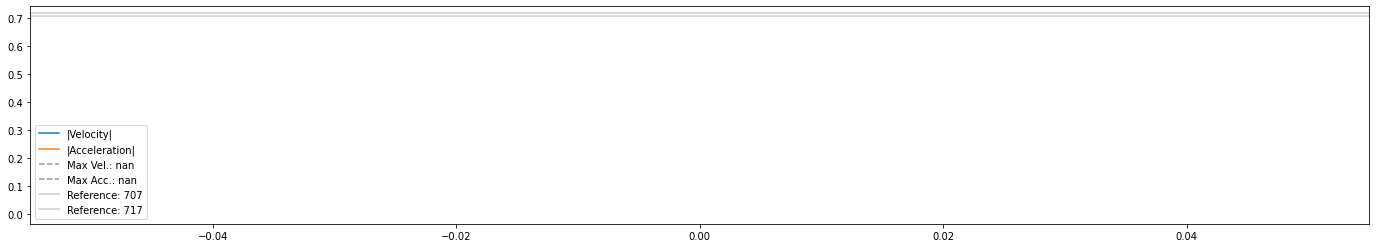

In [ ]:
# #0.12232663187172524
# #0.1542695253008115

# # get velocity and acceleration
# vel_abs, acc_abs, acc_parallel, acc_perp = \
#     get_vel_and_acc(mu_wrapper, t_data)

# plt.figure(figsize=(24, 4))
# plt.plot(vel_abs, label='|Velocity|')
# plt.plot(acc_abs, label='|Acceleration|')
# plt.axhline(np.max(vel_abs), ls='--', color='0.6', 
#            label='Max Vel.: {:3.3f}'.format(np.max(vel_abs)))
# plt.axhline(np.max(acc_abs), ls='--', color='0.6', 
#            label='Max Acc.: {:3.3f}'.format(np.max(acc_abs)))
# plt.axhline(.707, ls='-', color='.8', label='Reference: 707')
# plt.axhline(.717, ls='-', color='.8', label='Reference: 717')
# plt.legend()
# plt.show()

### Run Prediction on Test Data

In [ ]:
# from modules_lib.model import ModelWrapper
# %load_ext autoreload
# %autoreload 2
# import sys
# import os
# # Laptop GPU is busy with rendering screen ...
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
# import pickle
# import glob
# import pandas as pd
# import numpy as np
# from tqdm.notebook import tqdm
# from matplotlib import pyplot as plt
# from matplotlib.animation import FuncAnimation

# model_file_i = 'data/models/model_coords_0001'

# model_wrapper = ModelWrapper(model_file_i)


2022-09-10 00:14:36.928634: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-10 00:14:39.301138: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-10 00:14:39.301175: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: irfanflw-XPS-15-9510
2022-09-10 00:14:39.301179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: irfanflw-XPS-15-9510
2022-09-10 00:14:39.301317: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-10 00:14:39.301334: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-10 00:14:39.

Loaded Model with settings:
	add_coordinates: True
	sensor_norm_file: data/normalization/sensor_normalization_eqFalse_trTrue_09092022.pkl


In [ ]:
from modules_lib.data import KEYS as keys
from modules_lib.data import get_data_from_data_frame
from modules_lib.data import read_data

test_file = '../Dataset_sensor_floor/Dataset_Final/02092022/test/test.csv'

frames_test, y_test, t_test, X_test = read_data(test_file)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

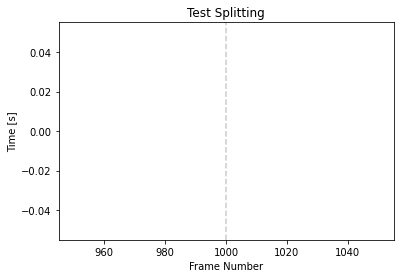

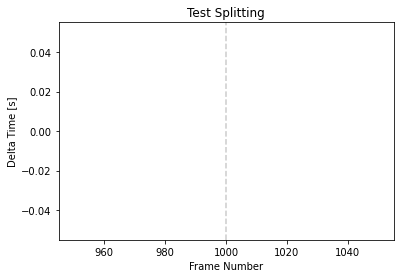

In [ ]:
# dt = np.diff(t_test, axis=0)
# indices = np.arange(len(dt)) + 1
# mask = np.abs(dt[:, 0]) > 3
# break_indices = np.append(indices[mask], len(t_test))

# plt.title('Test Splitting')
# plt.plot(t_test)
# for b in break_indices:
#     plt.axvline(b, color='0.8', ls='--')
# #plt.xlim(break_indices[1]-2, break_indices[1]+2)
# plt.ylabel('Time [s]')
# plt.xlabel('Frame Number')
# plt.show()

# plt.title('Test Splitting')
# plt.plot(dt)
# for b in break_indices:
#     plt.axvline(b, color='0.8', ls='--')
# plt.ylabel('Delta Time [s]')
# plt.xlabel('Frame Number')
# plt.show()


In [ ]:
# frames_test_list = []
# y_test_list = []
# t_test_list = []
# X_test_list = []

# last_index = 0
# for b in break_indices:
#     y_test_list.append(y_test[last_index:b])
#     t_test_list.append(t_test[last_index:b])
#     X_test_list.append(X_test[last_index:b])
#     frames_test_list.append(frames_test[last_index:b])
    
#     plt.hist(np.diff(t_test_list[-1], axis=0), bins=100,
#              density=True, histtype='step')
#     print(np.sum(np.diff(t_test_list[-1], axis=0)>3),
#           len(t_test_list[-1]))
    
#     last_index = b

# assert len(X_test) == np.sum([len(t) for t in X_test_list])

# plt.xlabel('Delta Time [s]')
# plt.show()

In [ ]:
#test predict
#missing nodes: 7-13, 20-9, 21-6, 23-5
#X_input_test = np.reshape(X_test[750], [-1, 23, 15, 10])
#t_input_test = np.reshape(t_test[750], [-1, 1])
mu = model_wrapper.predict(X_test[600:700], t_test[600:700])
#mu = model_wrapper.predict(X_input_test, t_input_test)
mu


X_shape predict: (100, 23, 15, 10)
Mean failed:
[ 2.52769574  2.11469893  2.01689976  2.13655972  2.1841558   2.48820619
  2.27163116  2.04794307  2.09420184  2.67370832  2.42506744  2.00234469
  2.19287678  2.16328662  2.74268967 20.95594109 15.72785453  2.55092002
  3.48959289 47.68645965 30.58315704  3.08411082  2.93256176  2.71963934
  4.1401061   2.5022654   2.91553551  2.13021922  2.26061054  2.47818762
  2.70079374  2.72996978  2.23423989  2.10298396  2.30470816  2.03760031
  2.0871273   2.01279234  2.0699952   2.63838435  2.80477958  2.07109898
  2.33754495  2.0219773   2.67198975  2.25460091  2.57470283  2.52148915
  2.4009316   2.00586955  2.04160517  2.21027763  3.14385261  4.36474806
  2.0215998   2.06761641  2.50996465  2.12459789  2.87532438  2.06013863
  2.07719467  2.70884433  2.6421973   2.23617619  2.08088192  2.02105751
 10.5800447  12.22558123  2.042568    2.42482621  2.2087959   2.08071646
  2.21301584  2.81958104  2.93126286 18.31372955 26.53927824 31.49116466
  2

array([[-8.10331535, -1.67687297],
       [-8.2622261 , -1.50283778],
       [-7.95906401, -1.57945502],
       [-7.92665243, -1.79115641],
       [-7.95022392, -1.80132627],
       [-8.12870121, -1.23408628],
       [-8.27360439, -1.50901151],
       [-8.68773746, -1.15676391],
       [-8.10086536, -1.69281769],
       [-8.27351665, -1.41581464],
       [-8.04591942, -1.72014296],
       [-8.2480526 , -1.66903329],
       [-6.94201851,  1.18560708],
       [-7.98281765, -1.62754107],
       [-8.40592957, -1.26472175],
       [-7.96503639, -1.57615435],
       [-8.20188141, -1.64577448],
       [-7.76567221, -1.65509212],
       [-8.67778969, -1.1321013 ],
       [-8.11181068, -1.75425458],
       [-8.55084705, -1.15151751],
       [-7.98851919, -1.58179855],
       [-8.08037281, -1.72007453],
       [-8.0446167 , -1.75733769],
       [-8.36953354, -1.50211167],
       [-8.47458553, -1.17407656],
       [-8.07040787, -1.70313668],
       [-8.00831223, -1.76742125],
       [-8.63592148,

In [ ]:
# num_frames = 100
# use_wrapper = True

# y_test_pred = []

# for split in tqdm(range(len(X_test_list))):
#     X_test_i = np.array(X_test_list[split])
#     t_test_i = np.array(t_test_list[split])
#     y_test_i = np.array(y_test_list[split])
    
#     if use_wrapper:
#         mu = model_wrapper.predict(X_test_i, t_test_i)
#     else:

#         X_test_norm_i = np.array((X_test_i - sensor_bias) / sensor_std)
#         X_test_norm_i[~np.isfinite(X_test_norm_i)] = 0
#         X_test_norm_i = X_test_norm_i[..., 6:]

#         y_test_pred_i = model.predict(X_test_norm_i)

#         mu = y_test_pred_i[..., :2]
#         sigma = y_test_pred_i[..., 2:4]
#         r = y_test_pred_i[..., 4:]

#         # Run Evaluation
#         vel, acc = get_vel_and_acc(mu, t_test_i)[:2]
#         print(np.max(vel), np.max(acc))

#         mu = postprocess(mu, sigma, r, t_test_i, 
#                          pre_fitting_size=None)

#     # Run Evaluation
#     vel, acc = get_vel_and_acc(mu, t_test_i)[:2]
#     print(np.max(vel), np.max(acc))
    
#     # append reconstructed positions to list
#     y_test_pred.append(mu)
    
    
# y_test_pred = np.concatenate(y_test_pred, axis=0)

# if False:
#     create_complete_gif2(
#         run, 
#         file_name='plots/gif_test_{norm}.gif',
#         normalized=True, num_frames=num_frames,
#         y_pred=y_test_pred,
#     )

NameError: name 'X_test_list' is not defined

In [ ]:
# print(len(y_test_pred), len(X_test))
# assert len(y_test_pred) == len(X_test), len(y_test_pred)

# data_dict = {
#     'frame_number': range(len(y_test_pred)),
#     'vicon_x': y_test_pred[:, 0],
#     'vicon_y': y_test_pred[:, 1],
# }

# df_test_pred = pd.DataFrame(data_dict)
# df_test_pred = df_test_pred.set_index('frame_number')
# print(df_test_pred.head())

# test_pred_file = 'data/test_submission_{}_{:03d}.csv'
# for i in range(1000):
#     test_pred_file_i = test_pred_file.format(
#         os.path.basename(model_file_i), i)
#     if not os.path.exists(test_pred_file_i):
#         print('Saving prediction to:', test_pred_file_i)
#         df_test_pred.to_csv(test_pred_file_i)
#         break

#### Check Resolution

In [ ]:
# t_test_pred = []
# for split in tqdm(range(len(X_test_list))):
#     t_test_i = np.array(t_test_list[split])
#     t_test_pred.append(t_test_i)
# t_test_pred = np.concatenate(t_test_pred, axis=0)

# # get velocity and acceleration
# vel_abs, acc_abs, acc_parallel, acc_perp = \
#     get_vel_and_acc(y_test_pred, t_test_pred)

# plt.figure(figsize=(64, 4))
# plt.plot(vel_abs, label='|Velocity|')
# plt.plot(acc_abs, label='|Acceleration|')
# plt.axhline(np.max(vel_abs), ls='--', color='0.6', 
#            label='Max Vel.: {:3.3f}'.format(np.max(vel_abs)))
# plt.axhline(np.max(acc_abs), ls='--', color='0.6', 
#            label='Max Acc.: {:3.3f}'.format(np.max(acc_abs)))
# plt.axhline(.707, ls='-', color='.8', label='Reference: 707')
# plt.axhline(.717, ls='-', color='.8', label='Reference: 717')
# plt.legend()
# plt.show()
    

NameError: name 'X_test_list' is not defined

In [ ]:
# create_y_gif(
#     y_pred=y_test_pred[::5], 
#     y_true=None, 
#     file_name='plots/gif_y_prediction.gif')